# Fixing Employee Happiness at TechTrend Innovations - Assignment 02

You should complete this Jupyter Notebook with your answers. You may need to write code or add explanatory notes.

dataset link: https://www.kaggle.com/datasets/lainguyn123/employee-survey/data

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
RANDOM_STATE = 42

In [3]:
# Load and print head of the dataset
data = pd.read_csv(f"employee_survey.csv")
data.head()

,EmpID,Gender,Age,MaritalStatus,JobLevel,Experience,Dept,EmpType,WLB,WorkEnv,...,SleepHours,CommuteMode,CommuteDistance,NumCompanies,TeamSize,NumReports,EduLevel,haveOT,TrainingHoursPerYear,JobSatisfaction
0,6,Male,32,Married,Mid,7,IT,Full-Time,1,1,...,7.6,Car,20,3,12,0,Bachelor,True,33.5,5
1,11,Female,34,Married,Mid,12,Finance,Full-Time,1,1,...,7.9,Car,15,4,11,0,Bachelor,False,36.0,5
2,33,Female,23,Single,Intern/Fresher,1,Marketing,Full-Time,2,4,...,6.5,Motorbike,17,0,30,0,Bachelor,True,10.5,5
3,20,Female,29,Married,Junior,6,IT,Contract,2,2,...,7.5,Public Transport,13,2,9,0,Bachelor,True,23.0,5
4,28,Other,23,Single,Junior,1,Sales,Part-Time,3,1,...,4.9,Car,20,0,7,0,Bachelor,False,20.5,5


## Background

Imagine a grumpy CEO, MR. Bluffington, who’s obsessed with making it look like his employees are thrilled to be at work. To pull off this illusion, he hires a sneaky hacker group called Hack&Cheese to break into company records—including those at TechTrend Innovations—and boost the JobSatisfaction scores (1–5) to make it seem like everyone’s loving their job!

This messes up important tools people rely on: performance trackers used for promotions, health insurers calculating coverage costs, and job platforms helping folks find the right work. These systems are now totally confused… until a new survey rolls in.

But wait—you have a secret copy of TechTrend’s original, unaltered data from before the hack!

Let’s expose the truth and stop Bluffington’s data deception!

## Task 1: Fixing TechTrend’s Data to Beat General Victor Smirkov’s Hack
Mr. Bluffingtion’s hackers messed up TechTrend’s happiness numbers, but your real data can fix it.  
- Make a new target, `SatisfactionLevel`, where `JobSatisfaction` 3-5 is "Satisfied" and 1-2 is "Dissatisfied". Then remove `JobSatisfaction`—it’s fake outside, and we’re making it new.  
- Clean the rest: turn words like `Gender` or `Dept` into numbers, adjust numbers like `Age` or `HoursWorkload`, and fill any blanks.

In [4]:
df = data.copy()

In [5]:
df['SatisfactionLevel'] = df['JobSatisfaction'].apply(lambda x: 1 if x > 2 else 0)
df.drop('JobSatisfaction', axis=1, inplace=True)

In [6]:
df['EmpID'].duplicated().sum()

np.int64(0)

In [7]:
# There are no duplicates in the EmpID column, so we can drop it
df.drop('EmpID', axis = 1, inplace=True)

In [8]:
df.shape

(3025, 22)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gender                 3025 non-null   object 
 1   Age                    3025 non-null   int64  
 2   MaritalStatus          3025 non-null   object 
 3   JobLevel               3025 non-null   object 
 4   Experience             3025 non-null   int64  
 5   Dept                   3025 non-null   object 
 6   EmpType                3025 non-null   object 
 7   WLB                    3025 non-null   int64  
 8   WorkEnv                3025 non-null   int64  
 9   PhysicalActivityHours  3025 non-null   float64
 10  Workload               3025 non-null   int64  
 11  Stress                 3025 non-null   int64  
 12  SleepHours             3025 non-null   float64
 13  CommuteMode            3025 non-null   object 
 14  CommuteDistance        3025 non-null   int64  
 15  NumC

There are no null values, we will check for invalid data later.

In [10]:
df['Gender'].value_counts()

Gender
Male      1528
Female    1240
Other      257
Name: count, dtype: int64

In [11]:
df['MaritalStatus'].value_counts()

MaritalStatus
Single      1437
Married     1397
Divorced     189
Widowed        2
Name: count, dtype: int64

In [12]:
df['JobLevel'].value_counts()

JobLevel
Senior            1069
Mid                766
Junior             602
Lead               386
Intern/Fresher     202
Name: count, dtype: int64

In [13]:
df['JobLevel'] = df['JobLevel'].apply(lambda x: ['Intern/Fresher', 'Junior', 'Mid', 'Senior', 'Lead'].index(x))

JobLevel and EduLevel are encoded ordinally because they have natural hierarchical order (Intern < Junior < Mid < Senior < Lead, and High School < Bachelor < Master < PhD). This preserves the meaningful ranking relationships, unlike other categorical variables that have no inherent order.

In [14]:
df['Dept'].value_counts()

Dept
IT                  774
Finance             637
Operations          455
Marketing           316
Sales               281
Legal               272
Customer Service    147
HR                  143
Name: count, dtype: int64

In [15]:
df['EmpType'].value_counts()

EmpType
Full-Time    2077
Part-Time     640
Contract      308
Name: count, dtype: int64

In [16]:
df['CommuteMode'].value_counts()

CommuteMode
Car                 1087
Public Transport     895
Bike                 436
Motorbike            310
Walk                 297
Name: count, dtype: int64

In [17]:
df['EduLevel'].value_counts()

EduLevel
Bachelor       2300
Master          380
High School     245
PhD             100
Name: count, dtype: int64

In [18]:
df['EduLevel'] = df['EduLevel'].apply(lambda x: ['High School', 'Bachelor', 'Master', 'PhD'].index(x))

In [19]:
df_one_hot = pd.get_dummies(data=df, columns=['Gender', 'MaritalStatus', 'Dept', 'EmpType', 'CommuteMode'])
df_one_hot.head()

,Age,JobLevel,Experience,WLB,WorkEnv,PhysicalActivityHours,Workload,Stress,SleepHours,CommuteDistance,...,Dept_Operations,Dept_Sales,EmpType_Contract,EmpType_Full-Time,EmpType_Part-Time,CommuteMode_Bike,CommuteMode_Car,CommuteMode_Motorbike,CommuteMode_Public Transport,CommuteMode_Walk
0,32,2,7,1,1,2.5,2,1,7.6,20,...,False,False,False,True,False,False,True,False,False,False
1,34,2,12,1,1,1.8,2,2,7.9,15,...,False,False,False,True,False,False,True,False,False,False
2,23,0,1,2,4,2.1,5,4,6.5,17,...,False,False,False,True,False,False,False,True,False,False
3,29,1,6,2,2,1.9,3,1,7.5,13,...,False,False,True,False,False,False,False,False,True,False
4,23,1,1,3,1,3.7,2,1,4.9,20,...,False,True,False,False,True,False,True,False,False,False


In [20]:
df_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           3025 non-null   int64  
 1   JobLevel                      3025 non-null   int64  
 2   Experience                    3025 non-null   int64  
 3   WLB                           3025 non-null   int64  
 4   WorkEnv                       3025 non-null   int64  
 5   PhysicalActivityHours         3025 non-null   float64
 6   Workload                      3025 non-null   int64  
 7   Stress                        3025 non-null   int64  
 8   SleepHours                    3025 non-null   float64
 9   CommuteDistance               3025 non-null   int64  
 10  NumCompanies                  3025 non-null   int64  
 11  TeamSize                      3025 non-null   int64  
 12  NumReports                    3025 non-null   int64  
 13  Edu

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df_one_hot.drop('SatisfactionLevel', axis=1), df_one_hot['SatisfactionLevel'], test_size=0.2, stratify=df_one_hot['SatisfactionLevel'], random_state=RANDOM_STATE)

Columns WLB, WorkEnv, Workload, Stress are numbers between 1(or zero) and 5.

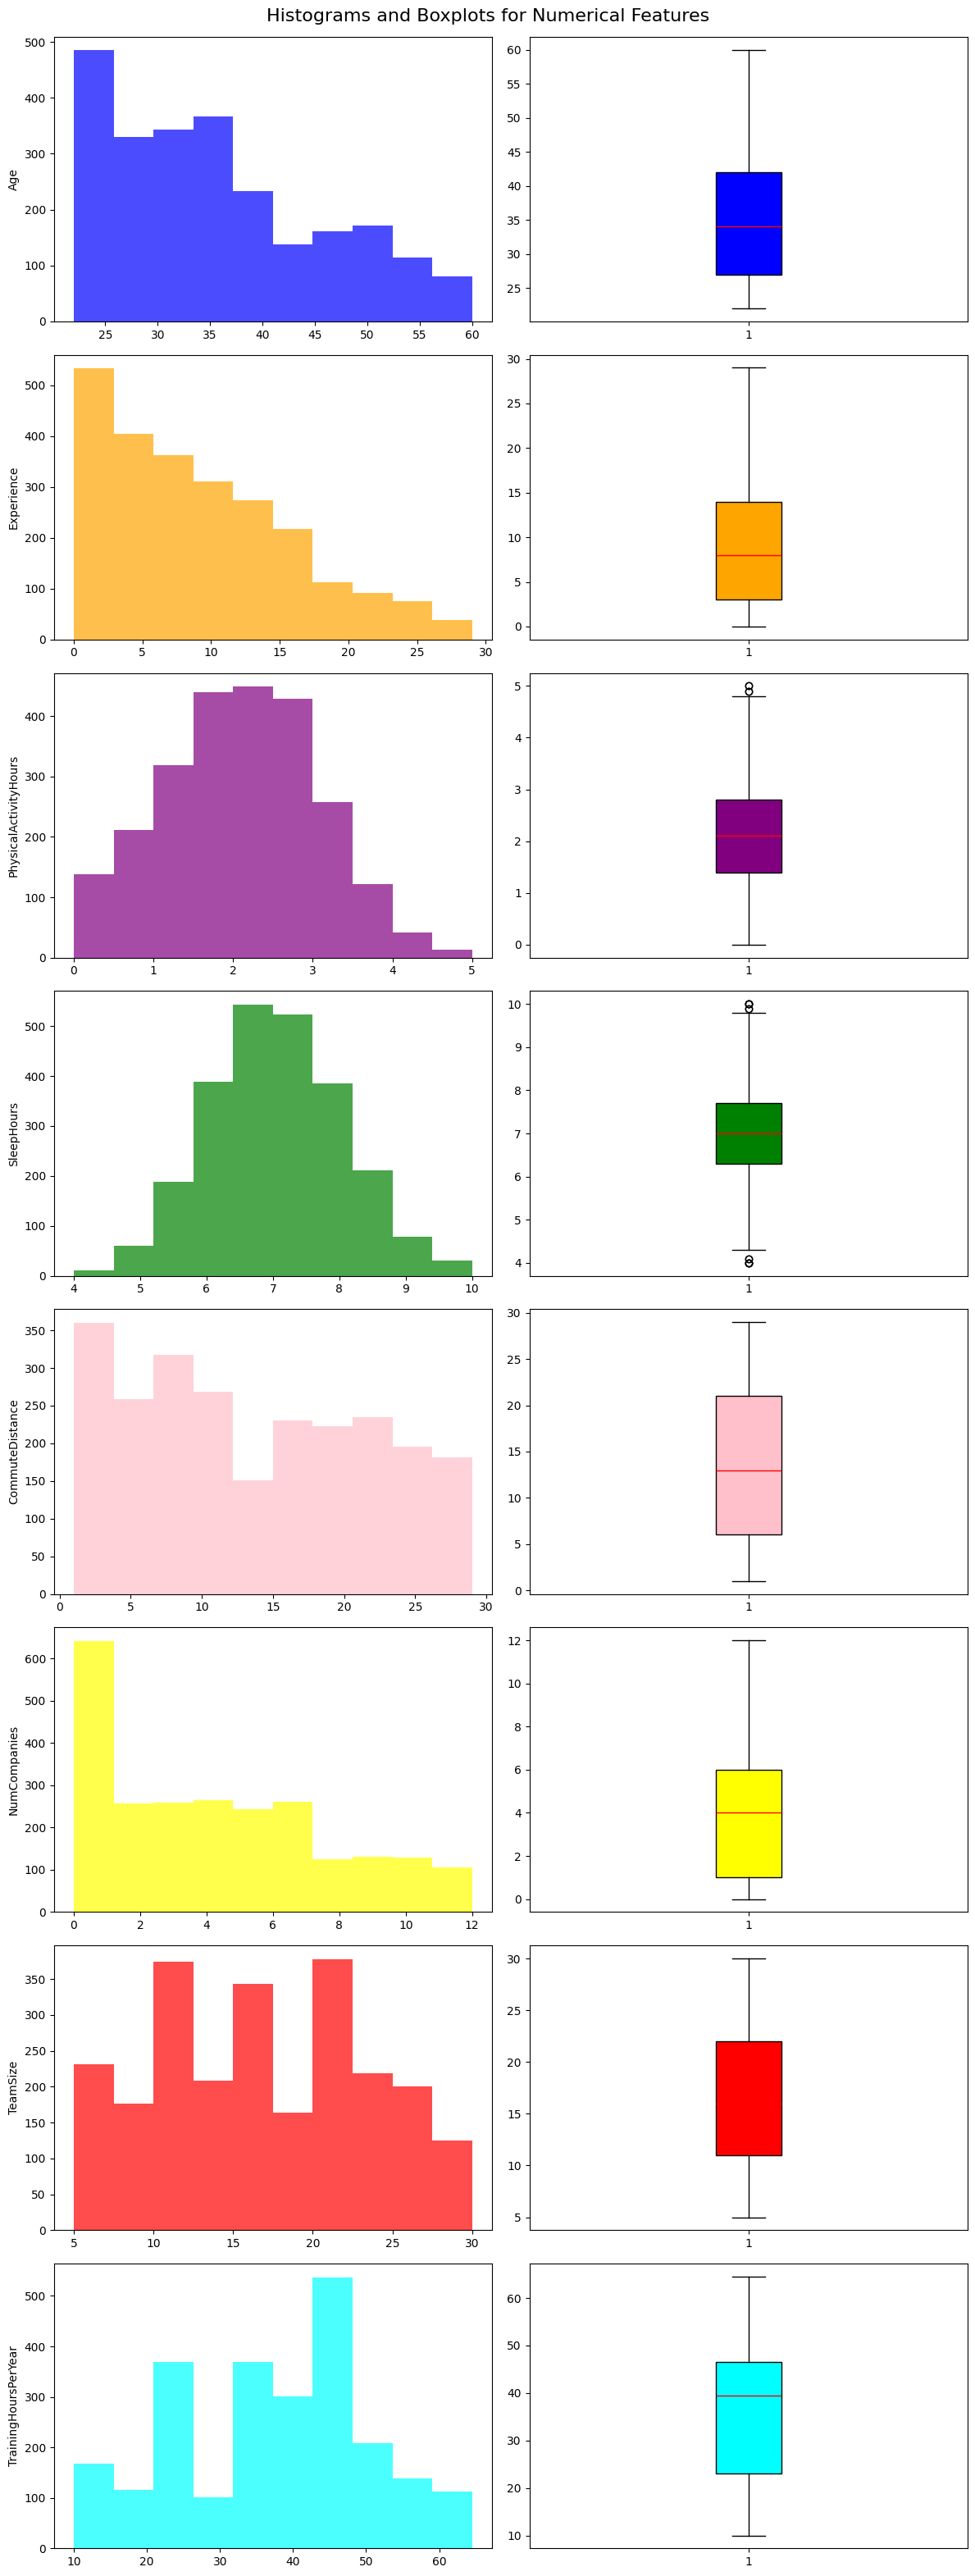

In [22]:
features = ['Age', 'Experience', 'PhysicalActivityHours', 'SleepHours',
            'CommuteDistance', 'NumCompanies', 'TeamSize', 'TrainingHoursPerYear']
feature_colors = {
    'Age': 'blue',
    'Experience': 'orange',
    'PhysicalActivityHours': 'purple',
    'SleepHours': 'green',
    'CommuteDistance': 'pink',
    'NumCompanies': 'yellow',
    'TeamSize': 'red',
    'TrainingHoursPerYear': 'cyan'
}

fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(12, 4 * len(features)))

for i, feature in enumerate(features):
    color = feature_colors[feature]
    
    axes[i, 0].hist(X_train[feature], bins=10, color=color, alpha=0.7)
    axes[i, 0].set_ylabel(feature)
    
    axes[i, 1].boxplot(X_train[feature], patch_artist=True,
                       boxprops=dict(facecolor=color, color='black'),
                       medianprops=dict(color='red'))
    
fig.suptitle("Histograms and Boxplots for Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.985])
plt.show()

PhysicalActivityHours and SleepHours look normal(although they might not be actually normal), so we can roughly fit them into a normal distribution, so we use standard scaler for these two features and minmax scaler for the rest.

But before we do that, the mentioned columns seem to have some outliers, so we will use the IQR method to remove them.

In [23]:
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound))

In [24]:
outliers_physical_activity = find_outliers(df['PhysicalActivityHours'])
outliers_sleep_hours = find_outliers(df['SleepHours'])

print(f"Outliers in PhysicalActivityHours: {outliers_physical_activity.sum()}")
print(f"Outliers in SleepHours: {outliers_sleep_hours.sum()}")

Outliers in PhysicalActivityHours: 4
Outliers in SleepHours: 14


In [25]:
df = df.drop(df[outliers_physical_activity | outliers_sleep_hours].index)
df.reset_index(drop=True, inplace=True)
df.shape

(3007, 22)

In [26]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

cols_standard = ['SleepHours', 'PhysicalActivityHours']
cols_minmax = ['Age', 'Experience', 'CommuteDistance', 'NumCompanies', 'TeamSize', 'TrainingHoursPerYear']

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

X_train_scaled[cols_standard] = standard_scaler.fit_transform(X_train[cols_standard])
X_test_scaled[cols_standard] = standard_scaler.transform(X_test[cols_standard])

X_train_scaled[cols_minmax] = minmax_scaler.fit_transform(X_train[cols_minmax])
X_test_scaled[cols_minmax] = minmax_scaler.transform(X_test[cols_minmax])

Scaling ensures that features contribute equally to the model. Standard scaling is used for normal-looking distributed features, while min-max scaling is applied to features with a fixed range.other features.

In [27]:
df_train_scaled = pd.concat([X_train_scaled, y_train], axis=1)
df_train_scaled

,Age,JobLevel,Experience,WLB,WorkEnv,PhysicalActivityHours,Workload,Stress,SleepHours,CommuteDistance,...,Dept_Sales,EmpType_Contract,EmpType_Full-Time,EmpType_Part-Time,CommuteMode_Bike,CommuteMode_Car,CommuteMode_Motorbike,CommuteMode_Public Transport,CommuteMode_Walk,SatisfactionLevel
2922,0.736842,4,0.965517,5,4,0.363992,3,5,0.197924,0.607143,...,False,False,False,True,False,True,False,False,False,1
1558,0.052632,1,0.068966,2,3,-0.254084,5,1,0.297008,0.321429,...,False,False,True,False,False,False,False,True,False,1
1363,0.000000,1,0.000000,1,4,1.394118,4,1,-0.099330,0.000000,...,False,True,False,False,False,False,False,False,True,0
2861,0.763158,4,0.931034,5,5,0.054954,1,1,0.297008,0.964286,...,False,False,True,False,False,True,False,False,False,1
1619,0.026316,0,0.034483,5,1,0.879055,4,1,-1.090177,0.000000,...,False,False,True,False,False,False,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,0.710526,2,0.758621,5,2,-0.769147,3,1,-1.288346,0.000000,...,False,True,False,False,True,False,False,False,False,1
1455,0.052632,1,0.068966,5,5,0.570017,5,1,0.792431,0.357143,...,False,False,False,True,False,True,False,False,False,1
1630,0.473684,3,0.620690,5,2,-0.048058,1,1,0.495177,0.392857,...,False,False,True,False,False,False,True,False,False,1
2830,0.421053,3,0.137931,2,1,-0.563122,4,1,0.792431,0.035714,...,False,False,True,False,False,False,False,False,True,0


## Task 2: Showing the Real Satisfaction Split at TechTrend
The CEO says all workers are happy, but your data might prove him wrong. Let’s look.  
- Count how many are Satisfied vs. Dissatisfied in `SatisfactionLevel` and show the numbers.  
- Make a picture (like a bar chart) to show if more are Satisfied or not.

In [28]:
pd.concat(
    [df_train_scaled['SatisfactionLevel'].map({0: 'Dissatisfied', 1: 'Satisfied'}).value_counts(),
    df_train_scaled['SatisfactionLevel'].map({0: 'Dissatisfied', 1: 'Satisfied'}).value_counts(normalize=True)],
    axis=1
)

,count,proportion
SatisfactionLevel,,
Satisfied,1865,0.770661
Dissatisfied,555,0.229339


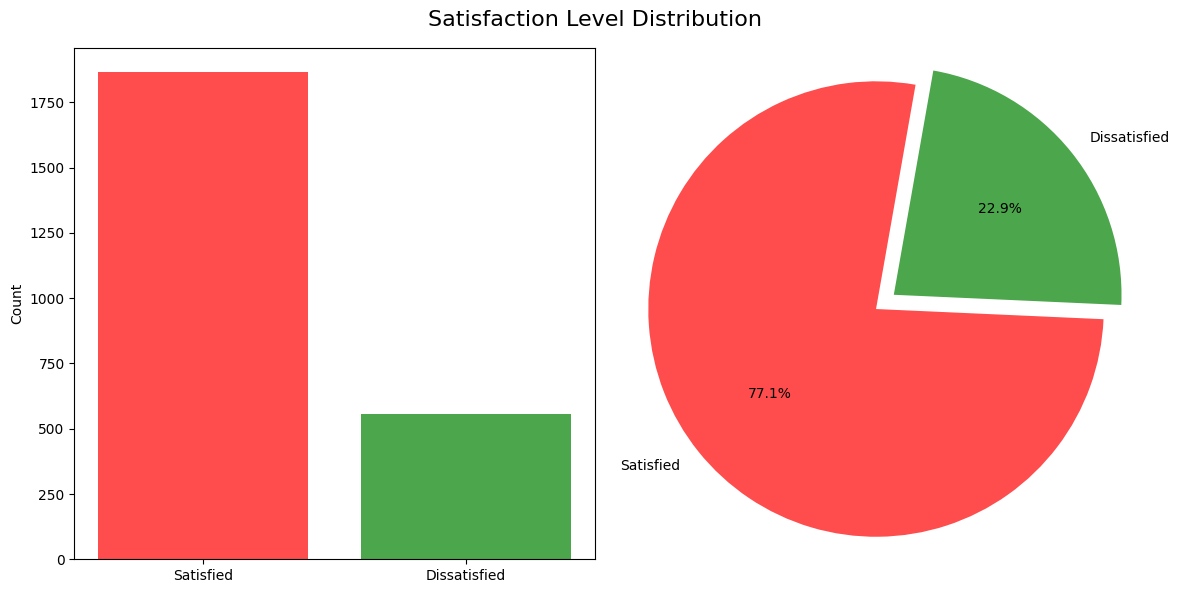

In [29]:
counts = df_train_scaled['SatisfactionLevel'].map({0: 'Dissatisfied', 1: 'Satisfied'}).value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.bar(counts.index, counts.values, color=['red', 'green'], alpha=0.7)
ax1.set_ylabel('Count')

ax2.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=80, colors=['red', 'green'], wedgeprops={'alpha': 0.7}, explode=(0.1, 0))
ax2.axis('equal')

fig.suptitle('Satisfaction Level Distribution', fontsize=16)
plt.tight_layout()
plt.show()

The data reveals Mr. Bluffington's deception: only 77.1% of employees are actually satisfied, not the 100% he claims. Nearly 1 in 4 workers (22.9%) are dissatisfied, exposing a significant employee satisfaction problem that his fake data was designed to hide.

## Task 3: Digging Up What Really Shapes Satisfaction at TechTrend
TechTrend's tools need to know what changes happiness to work right. Let’s check it out.  
- Guess which things—like `haveOT`, `WLB`, or `HoursWorkload`—might affect `SatisfactionLevel`.  
- Explore how these factors relate to happiness, for example, using statistical methods, charts, or other analyses.

*In a markdown cell, tell your guesses and what the pictures show about TechTrend’s true workers.*

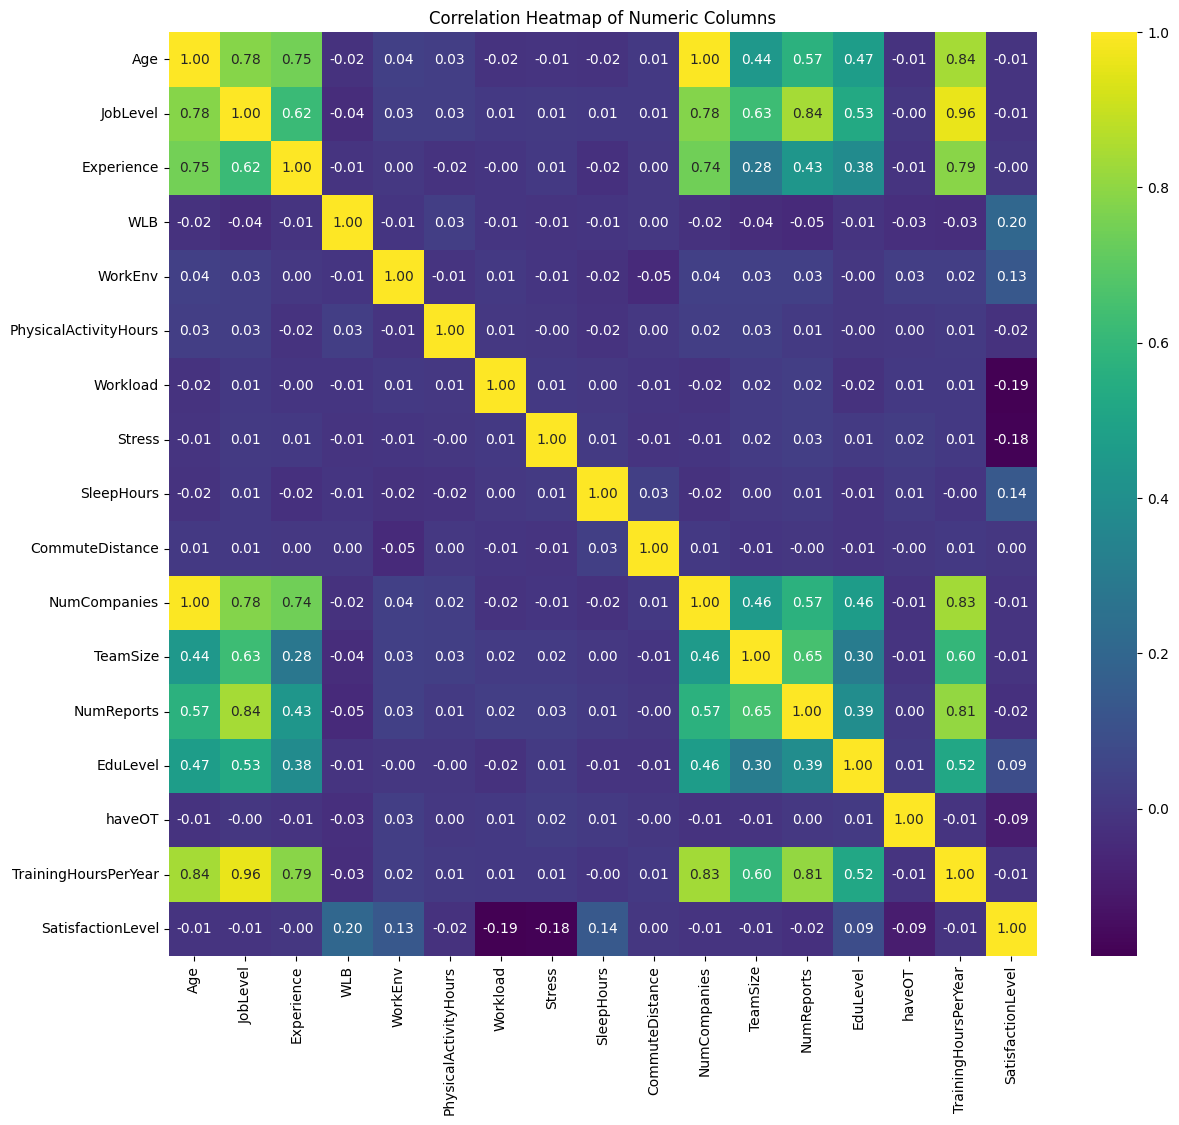

In [30]:
exclusion_prefixes = ['Gender_', 'MaritalStatus_', 'Dept_', 'EmpType_', 'CommuteMode_']

one_hot_columns = [col for col in df_train_scaled.columns if col.startswith(tuple(exclusion_prefixes))]
numerical_columns = [col for col in df_train_scaled.columns 
                if col not in one_hot_columns]

plt.figure(figsize=(14, 12))
sns.heatmap(data=df_train_scaled[numerical_columns].corr(method='spearman'), annot=True, fmt=".2f", cmap="viridis")
plt.title("Correlation Heatmap of Numeric Columns")
plt.show()

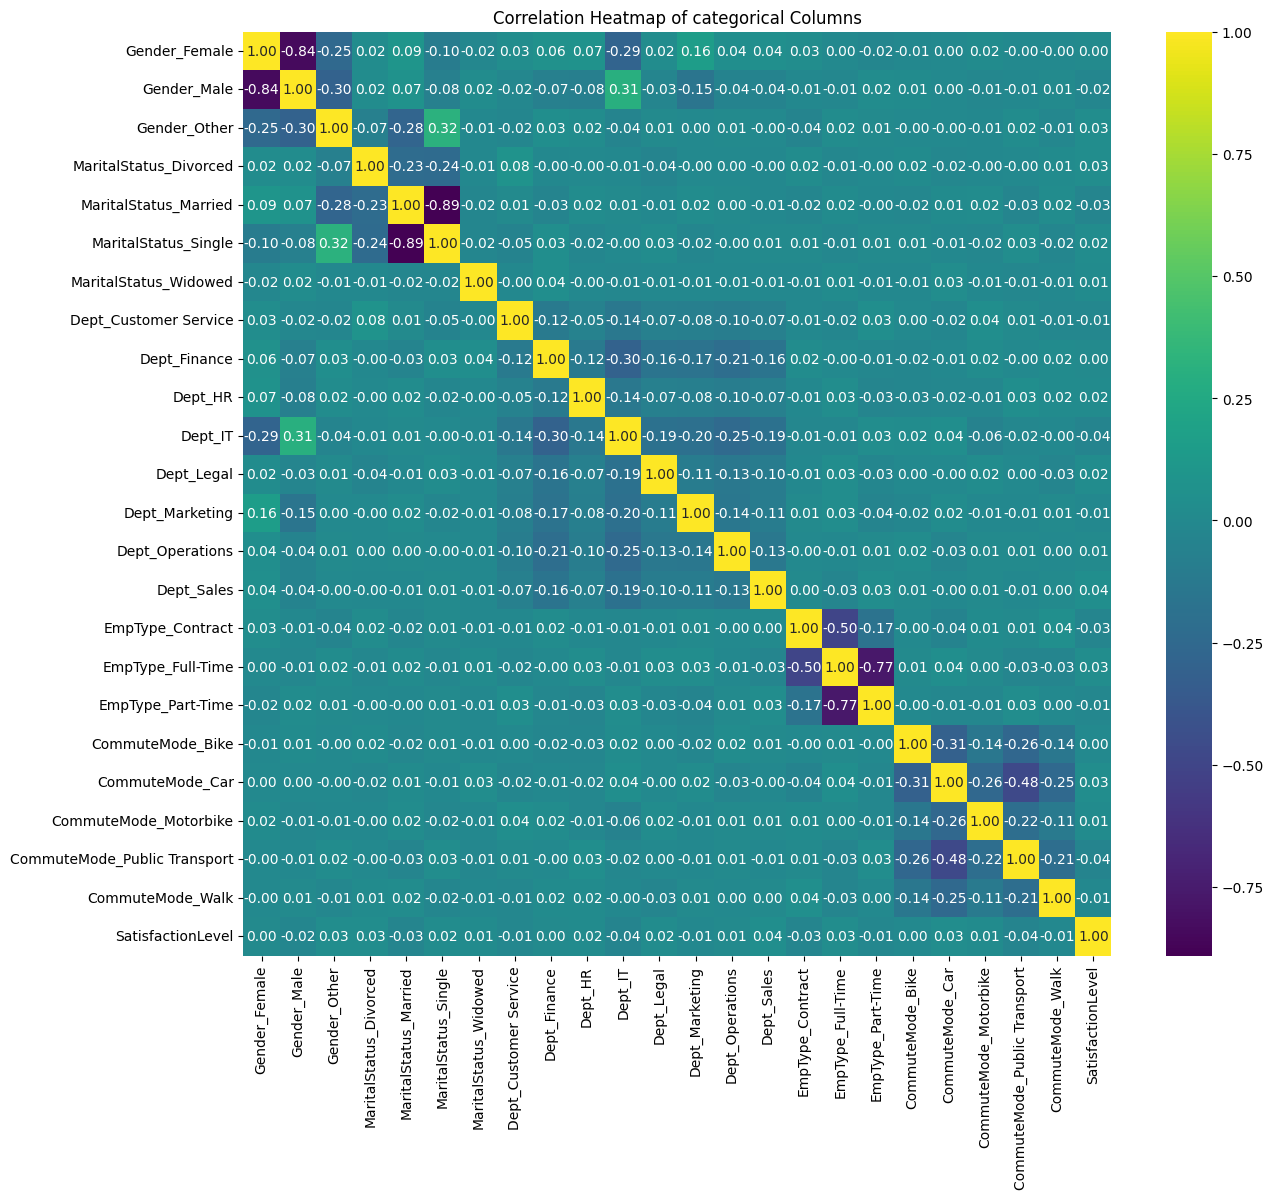

In [31]:
one_hot_columns.append('SatisfactionLevel')

plt.figure(figsize=(14, 12))
sns.heatmap(data=df_train_scaled[one_hot_columns].corr(), annot=True, fmt=".2f", cmap="viridis")
plt.title("Correlation Heatmap of categorical Columns")
plt.show()

The heatmaps reveal relationships between features and `SatisfactionLevel`. Strong correlations indicate features that may significantly impact employee satisfaction.

In [32]:
numerical_features = ['Age', 'JobLevel', 'Experience', 'WLB', 'WorkEnv', 'PhysicalActivityHours', 'Workload', 'Stress', 'SleepHours', 'CommuteDistance', 'NumCompanies', 'TeamSize', 'NumReports', 'EduLevel', 'TrainingHoursPerYear']

print("T-tests for Numerical/Ordinal Features:")
for feature in numerical_features:
    group0 = df[df['SatisfactionLevel'] == 0][feature]
    group1 = df[df['SatisfactionLevel'] == 1][feature]
    # Use Welch's t-test (assuming unequal variances)
    t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
    print(f"{feature}: t-stat = {t_stat:.3f}, p-value = {p_val:.3f}")

T-tests for Numerical/Ordinal Features:
Age: t-stat = 0.834, p-value = 0.405
JobLevel: t-stat = 0.300, p-value = 0.764
Experience: t-stat = 0.215, p-value = 0.830
WLB: t-stat = -10.871, p-value = 0.000
WorkEnv: t-stat = -8.349, p-value = 0.000
PhysicalActivityHours: t-stat = 1.054, p-value = 0.292
Workload: t-stat = 10.090, p-value = 0.000
Stress: t-stat = 8.350, p-value = 0.000
SleepHours: t-stat = -7.542, p-value = 0.000
CommuteDistance: t-stat = -0.476, p-value = 0.634
NumCompanies: t-stat = 0.733, p-value = 0.464
TeamSize: t-stat = 0.037, p-value = 0.970
NumReports: t-stat = 1.325, p-value = 0.185
EduLevel: t-stat = -3.468, p-value = 0.001
TrainingHoursPerYear: t-stat = 0.303, p-value = 0.762


In [33]:
categorical_features = ['Gender', 'MaritalStatus', 'Dept', 'EmpType', 'CommuteMode', 'haveOT']

print("\nChi-square tests for Categorical Features:")
for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['SatisfactionLevel'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"{feature}: chi2 = {chi2:.3f}, p-value = {p:.3f}, dof = {dof}")


Chi-square tests for Categorical Features:
Gender: chi2 = 1.591, p-value = 0.451, dof = 2
MaritalStatus: chi2 = 5.891, p-value = 0.117, dof = 3
Dept: chi2 = 7.486, p-value = 0.380, dof = 7
EmpType: chi2 = 3.223, p-value = 0.200, dof = 2
CommuteMode: chi2 = 4.629, p-value = 0.328, dof = 4
haveOT: chi2 = 31.125, p-value = 0.000, dof = 1


In [34]:
mi = mutual_info_classif(X_train_scaled, y_train, random_state=RANDOM_STATE)

mi_scores = pd.Series(mi, index=X_train_scaled.columns).sort_values(ascending=False)
mi_scores = mi_scores[mi_scores > 0.001]

print("Mutual Information Scores (above 0.001):")
print(mi_scores)

Mutual Information Scores (above 0.001):
EduLevel                        0.035920
TrainingHoursPerYear            0.018214
WLB                             0.017301
Dept_Operations                 0.015610
SleepHours                      0.014309
Experience                      0.012802
CommuteDistance                 0.012232
Age                             0.012107
TeamSize                        0.011887
Stress                          0.011471
Workload                        0.010367
MaritalStatus_Widowed           0.009690
CommuteMode_Walk                0.009152
EmpType_Part-Time               0.009130
CommuteMode_Motorbike           0.008896
NumCompanies                    0.007821
JobLevel                        0.007283
MaritalStatus_Married           0.005265
CommuteMode_Public Transport    0.003835
Gender_Female                   0.003685
PhysicalActivityHours           0.002624
Dept_Sales                      0.002346
Dept_Legal                      0.001802
WorkEnv         

According to correlations appears WLB, SleepHours, WorkEnv, WorkLoad and Stress Are important features.

T-Test tells us the same.

Chi-square test says that haveOT is an important feature.

and mutual informations sorted result can be seen above.

Interestingly, mutual information reveals different priorities than t-tests. While t-tests show WLB, Workload, and Stress as most significant (p < 0.001), mutual information ranks EduLevel and TrainingHoursPerYear highest. This suggests that immediate work conditions affect satisfaction differently than long-term career development factors - both matter but capture different aspects of employee experience.

## Task 4: Nailing the Big Clues to Stop General Victor Smirkov
Mr. Bluffington’s hack hid what’s real, but TechTrend needs the top reasons for happiness to fix its tools. Let’s find them.  
- Choose a way (like Recursive Feature Elimination or Correlation Thresholding) to pick the best features for guessing `SatisfactionLevel`.  
- List your top features and say why your way works for TechTrend.  

*In a markdown cell, tell how these features can help TechTrend’s tools win.*

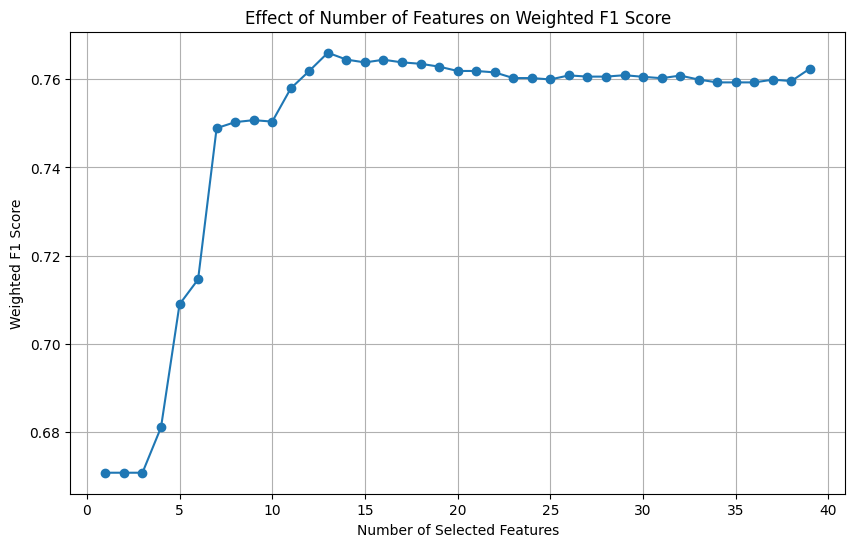

Best Weighted F1 Score: 0.7660 with 13 features
Best features:
['Age', 'Experience', 'WLB', 'WorkEnv', 'Workload', 'Stress', 'SleepHours', 'EduLevel', 'haveOT', 'MaritalStatus_Divorced', 'Dept_Customer Service', 'EmpType_Full-Time', 'CommuteMode_Public Transport']


In [35]:
estimator = LogisticRegression(max_iter=1000, solver="liblinear", random_state=RANDOM_STATE)

total_features = X_train_scaled.shape[1]
feature_range = range(1, total_features + 1)
cv_scores = []

for n_features in feature_range:
    rfe = RFE(estimator, n_features_to_select=n_features, step=1)
    rfe.fit(X_train_scaled, y_train)
    selected_features = X_train_scaled.columns[rfe.support_]
    
    scores = cross_val_score(estimator, X_train_scaled[selected_features], y_train, cv=5, scoring='f1_weighted')
    cv_scores.append(np.mean(scores))

# Plot CV accuracy versus number of features
plt.figure(figsize=(10, 6))
plt.plot(list(feature_range), cv_scores, marker='o', linestyle='-')
plt.xlabel("Number of Selected Features")
plt.ylabel("Weighted F1 Score")
plt.title("Effect of Number of Features on Weighted F1 Score")
plt.grid(True)
plt.show()

# Find the best number of features
best_idx = np.argmax(cv_scores)
best_n_features = list(feature_range)[best_idx]
print(f"Best Weighted F1 Score: {cv_scores[best_idx]:.4f} with {best_n_features} features")

# Run RFE with the best number of features and print the best feature set
rfe_best = RFE(estimator, n_features_to_select=best_n_features, step=1)
rfe_best.fit(X_train_scaled, y_train)
final_features = X_train_scaled.columns[rfe_best.support_].tolist()

print("Best features:")
print(final_features)

The RFE plot shows performance plateaus at 13 features, indicating diminishing returns beyond this point. The selected features reveal satisfaction drivers span three categories: work conditions (WLB, WorkEnv, Workload, Stress), personal factors (Age, Experience, SleepHours, EduLevel), and organizational context (haveOT, department, employment type, commute mode). This comprehensive set captures the multifaceted nature of job satisfaction.

## Task 5: Train a Model to Unmask the True Satisfaction  
Mr. Bluffington’s fake numbers won’t fool us! Use your Task 4 features to predict the real `SatisfactionLevel` (Satisfied or Dissatisfied). Pick a classifier—like Naive Bayes or any you prefer—and tweak at least one hyperparameter (e.g., smoothing) to make it sharp. Train it using cross-validation (e.g., k-fold) to ensure it’s tough enough to expose the truth.

In [36]:
log_model = LogisticRegression(random_state=RANDOM_STATE)

# Split the grid to avoid incompatible combinations (e.g., lbfgs with l1 penalty)
param_grid = [
    {   # For l1 penalty, use only solvers that support it.
        'penalty': ['l1'],
        'C': np.logspace(-4, 4, 30),
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 500, 1000, 5000, 10000],
        'class_weight': [None, 'balanced']
    },
    {   # For l2 penalty, include additional solvers.
        'penalty': ['l2'],
        'C': np.logspace(-4, 4, 39),
        'solver': ['lbfgs', 'liblinear', 'saga'],
        'max_iter': [100, 500, 1000, 5000, 10000],
        'class_weight': [None, 'balanced']
    }
]

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_search = GridSearchCV(log_model, param_grid=param_grid, scoring='f1_weighted', cv=cv, verbose=1, n_jobs=-1, error_score='raise')
grid_search.fit(X_train_scaled[final_features], y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation F1 score:", grid_search.best_score_)

y_prob = grid_search.predict_proba(X_test_scaled[final_features])

Fitting 5 folds for each of 1770 candidates, totalling 8850 fits
Best parameters: {'C': np.float64(0.615848211066026), 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.7661689779416057


In [37]:
y_prob

array([[0.02034751, 0.97965249],
       [0.30253927, 0.69746073],
       [0.04389962, 0.95610038],
       ...,
       [0.27291719, 0.72708281],
       [0.37510746, 0.62489254],
       [0.2559113 , 0.7440887 ]], shape=(605, 2))

In [37]:
y_pred = (y_prob[:, 1] >= 0.5).astype(int)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.24      0.34       139
           1       0.81      0.94      0.87       466

    accuracy                           0.78       605
   macro avg       0.68      0.59      0.60       605
weighted avg       0.75      0.78      0.75       605

[[ 34 105]
 [ 28 438]]


## Task 6: Reveal the Real Balance to Train Smarter  
Fake numbers hid the truth, but your secret data doesn’t lie. First, check the real split between Satisfied and Dissatisfied workers to see how things actually were before the hack. Then, use what you find to train your model fairly—apply techniques (like oversampling or using class weights) to handle any imbalance and make sure it predicts the true `SatisfactionLevel` accurately.

In [38]:
print("Before oversampling:", Counter(y_train))

# Determine the target count for the 0 class.
# For example, if you want to balance the 0 class to have as many samples as class 1:
target_count = Counter(y_train)[1]

# Set sampling_strategy to oversample only class 0 up to the count of class 1
oversampler = RandomOverSampler(sampling_strategy={0: target_count}, random_state=RANDOM_STATE)

# Resample the training set
X_train_over_sample, y_train_over_sample = oversampler.fit_resample(X_train_scaled[final_features], y_train)

print("After oversampling:", Counter(y_train_over_sample))

Before oversampling: Counter({1: 1865, 0: 555})
After oversampling: Counter({1: 1865, 0: 1865})


In [39]:
log_model = LogisticRegression(random_state=RANDOM_STATE)

# Split the grid to avoid incompatible combinations (e.g., lbfgs with l1 penalty)
param_grid = [
    {   # For l1 penalty, use only solvers that support it.
        'penalty': ['l1'],
        'C': np.logspace(-4, 4, 30),
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 500, 1000, 5000, 10000],
        'class_weight': [None, 'balanced']
    },
    {   # For l2 penalty, include additional solvers.
        'penalty': ['l2'],
        'C': np.logspace(-4, 4, 39),
        'solver': ['lbfgs', 'liblinear', 'saga'],
        'max_iter': [100, 500, 1000, 5000, 10000],
        'class_weight': [None, 'balanced']
    }
]

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_search = GridSearchCV(log_model, param_grid=param_grid, scoring='f1_weighted', cv=cv, verbose=1, n_jobs=-1, error_score='raise')
grid_search.fit(X_train_over_sample, y_train_over_sample)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation F1 score:", grid_search.best_score_)

y_prob_over_sample = grid_search.predict_proba(X_test_scaled[final_features])

Fitting 5 folds for each of 1770 candidates, totalling 8850 fits
Best parameters: {'C': np.float64(0.7278953843983146), 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.7230147599755247


In [40]:
y_pred_over_sample = (y_prob_over_sample[:, 1] >= 0.4).astype(int)
print(classification_report(y_test, y_pred_over_sample))
print(confusion_matrix(y_test, y_pred_over_sample))

              precision    recall  f1-score   support

           0       0.45      0.53      0.49       139
           1       0.85      0.81      0.83       466

    accuracy                           0.75       605
   macro avg       0.65      0.67      0.66       605
weighted avg       0.76      0.75      0.75       605

[[ 74  65]
 [ 89 377]]


In [41]:
# Check the original class distribution in y_train
print("Before undersampling:", Counter(y_train))

# Determine the target count (i.e., the count of the minority class)
target_count = Counter(y_train)[0]

# Set sampling_strategy to ensure both classes have the same count as the minority
undersampler = RandomUnderSampler(sampling_strategy={1: target_count}, random_state=RANDOM_STATE)

# Resample the training set
X_train_under_sample, y_train_under_sample = undersampler.fit_resample(X_train_scaled[final_features], y_train)

print("After undersampling:", Counter(y_train_under_sample))

Before undersampling: Counter({1: 1865, 0: 555})
After undersampling: Counter({0: 555, 1: 555})


In [42]:
log_model = LogisticRegression(random_state=RANDOM_STATE)

# Split the grid to avoid incompatible combinations (e.g., lbfgs with l1 penalty)
param_grid = [
    {   # For l1 penalty, use only solvers that support it.
        'penalty': ['l1'],
        'C': np.logspace(-4, 4, 30),
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 500, 1000, 5000, 10000],
        'class_weight': [None, 'balanced']
    },
    {   # For l2 penalty, include additional solvers.
        'penalty': ['l2'],
        'C': np.logspace(-4, 4, 39),
        'solver': ['lbfgs', 'liblinear', 'saga'],
        'max_iter': [100, 500, 1000, 5000, 10000],
        'class_weight': [None, 'balanced']
    }
]

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_search = GridSearchCV(log_model, param_grid=param_grid, scoring='f1_weighted', cv=cv, verbose=1, n_jobs=-1, error_score='raise')
grid_search.fit(X_train_under_sample, y_train_under_sample)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation F1 score:", grid_search.best_score_)

y_prob_under_sample = grid_search.predict_proba(X_test_scaled[final_features])

Fitting 5 folds for each of 1770 candidates, totalling 8850 fits
Best parameters: {'C': np.float64(0.615848211066026), 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.7148341363020589


In [43]:
y_pred_under_sample = (y_prob_under_sample[:, 1] >= 0.37).astype(int)
print(classification_report(y_test, y_pred_under_sample))
print(confusion_matrix(y_test, y_pred_under_sample))

              precision    recall  f1-score   support

           0       0.45      0.46      0.46       139
           1       0.84      0.83      0.84       466

    accuracy                           0.75       605
   macro avg       0.64      0.65      0.65       605
weighted avg       0.75      0.75      0.75       605

[[ 64  75]
 [ 78 388]]


Comparing the three approaches: Original model (78% accuracy, poor minority class recall), Oversampling (75% accuracy, balanced recall 53% vs 81%), and Undersampling (75% accuracy, similar balance). Oversampling with threshold 0.4 provides the best balance for identifying truly dissatisfied employees while maintaining overall accuracy - crucial for exposing hidden workplace issues.

## Task 7: Evaluate the Model and Analyze the Truth to Fix TechTrend’s Tools  
Time to prove Mr. Bluffington’s fakeout fails! Test your classifier with metrics like precision, recall, and F1-score to see how well it identifies true Satisfied and Dissatisfied workers. Then, analyze the results of these metrics to understand how your model exposes the real `SatisfactionLevel`, helping tools like job sites and performance trackers get back on track with the truth.

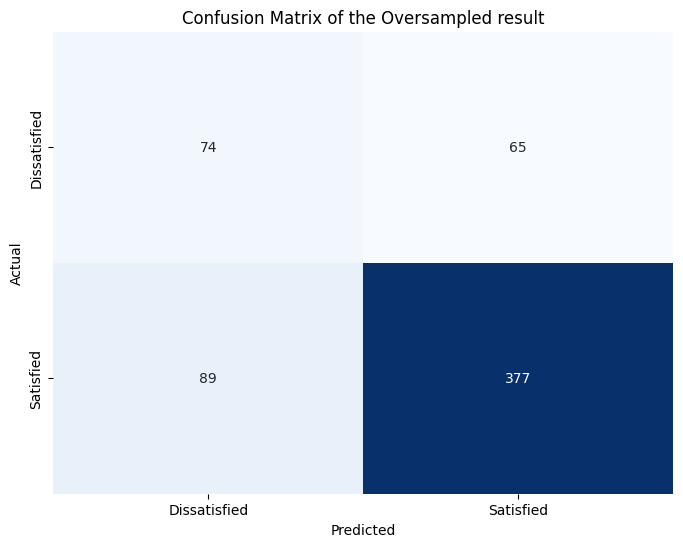

In [47]:
cm = confusion_matrix(y_test, y_pred_over_sample)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Dissatisfied', 'Satisfied'],
            yticklabels=['Dissatisfied', 'Satisfied'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of the Oversampled result')
plt.show()

The model successfully exposes Mr. Bluffington's deception. With 75% accuracy and ability to identify 53% of truly dissatisfied workers, it proves that real satisfaction patterns exist despite data manipulation. The confusion matrix shows 74 correctly identified dissatisfied employees out of 139 actual cases - these are the workers whose voices were silenced by fake data but can now be heard through our analysis.